In [1]:
# Data processing, preparing learning to recognise objects
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

data_dir = 'C:/Users/Dayo Tosin Oyeyemi/Desktop/Computer_vision/vehicles_images'

#defining parameters

batch_size = 32
img_height = 180
img_width = 180

#using keras/tensorflow method image_dataset_from_directory to transform my images into numeric metrics.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.
['bus', 'motorcycle', 'plane', 'train']


In [2]:
#using tensorflow's Autotune to pre-fetch the data, catch it for availablity for learning models
#tensorsflow's optimisation method
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

num_classes = 4

0.0 1.0


In [3]:
#defining CNN, I fed in the original image shape retrived above but rescale to range 0-1.
#using 3 convulation layers and 3 max pooling layers.
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [4]:
#model training, setting learning to 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_loss']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 101s 927ms/step - loss: 1.1510 - accuracy: 0.4975 - val_loss: 1.0473 - val_accuracy: 0.5678
Epoch 2/10
108/108 [==============================] - 97s 902ms/step - loss: 0.9372 - accuracy: 0.6148 - val_loss: 0.9811 - val_accuracy: 0.6234
Epoch 3/10
108/108 [==============================] - 98s 910ms/step - loss: 0.8025 - accuracy: 0.6808 - val_loss: 0.9165 - val_accuracy: 0.6373
Epoch 4/10
108/108 [==============================] - 103s 952ms/step - loss: 0.6369 - accuracy: 0.7612 - val_loss: 0.9385 - val_accuracy: 0.6362
Epoch 5/10
108/108 [==============================] - 98s 910ms/step - loss: 0.4228 - accuracy: 0.8466 - val_loss: 1.1108 - val_accuracy: 0.6072
Epoch 6/10
108/108 [==============================] - 96s 890ms/step - loss: 0.2934 - accuracy: 0.9077 - val_loss: 1.3488 - val_accuracy: 0.5875
Epoch 7/10
108/108 [==============================] - 100s 924ms/step - loss: 0.2080 - accuracy: 0.9415 - val_loss: 1.3962 - val

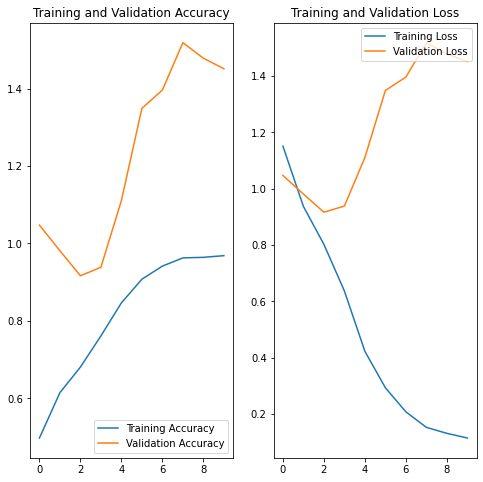

In [5]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(32, 180, 180, 3)
(32,)


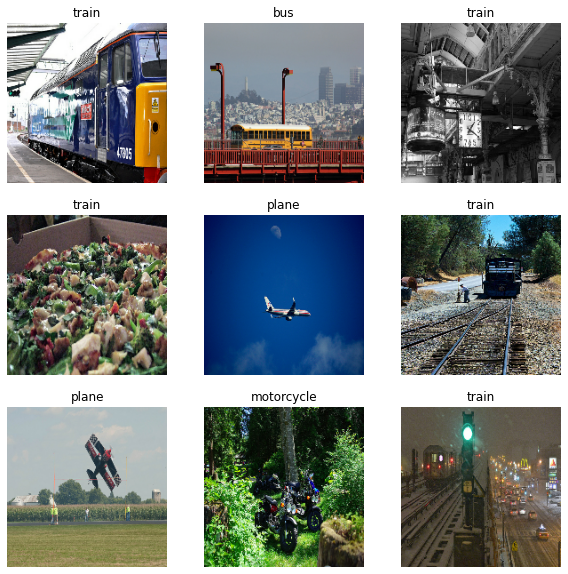

In [6]:
#transforming metrics back to images to comfirm format of images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

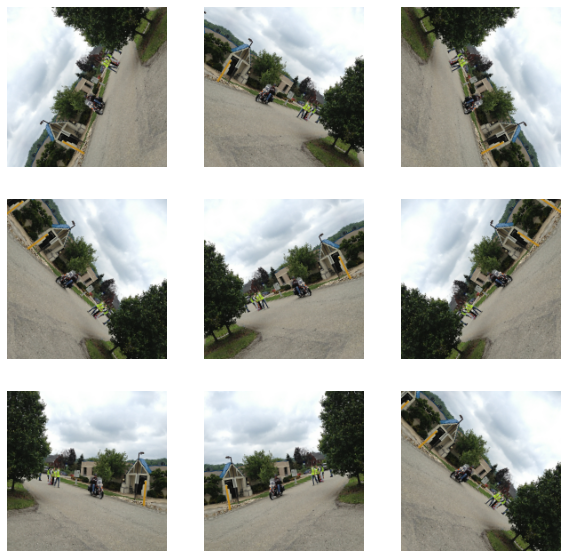

In [7]:
#using augmenation to improve performance
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
#running learning model again after augmentation to check effect on performance.
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_loss']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 152s 1s/step - loss: 0.1032 - accuracy: 0.9713 - val_loss: 1.4463 - val_accuracy: 0.5875
Epoch 2/10
108/108 [==============================] - 107s 988ms/step - loss: 0.0911 - accuracy: 0.9705 - val_loss: 1.5036 - val_accuracy: 0.6014
Epoch 3/10
108/108 [==============================] - 150s 1s/step - loss: 0.0879 - accuracy: 0.9705 - val_loss: 1.6297 - val_accuracy: 0.5817
Epoch 4/10
108/108 [==============================] - 165s 2s/step - loss: 0.0877 - accuracy: 0.9708 - val_loss: 1.5411 - val_accuracy: 0.6107
Epoch 5/10
108/108 [==============================] - 132s 1s/step - loss: 0.0851 - accuracy: 0.9708 - val_loss: 1.4815 - val_accuracy: 0.5829
Epoch 6/10
108/108 [==============================] - 128s 1s/step - loss: 0.0833 - accuracy: 0.9719 - val_loss: 1.6002 - val_accuracy: 0.5944
Epoch 7/10
108/108 [==============================] - 114s 1s/step - loss: 0.0748 - accuracy: 0.9711 - val_loss: 1.6396 - val_accuracy: 0.6

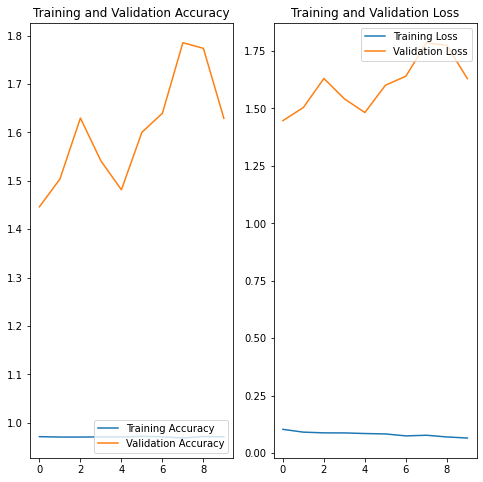

In [9]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(32, 180, 180, 3)
(32,)


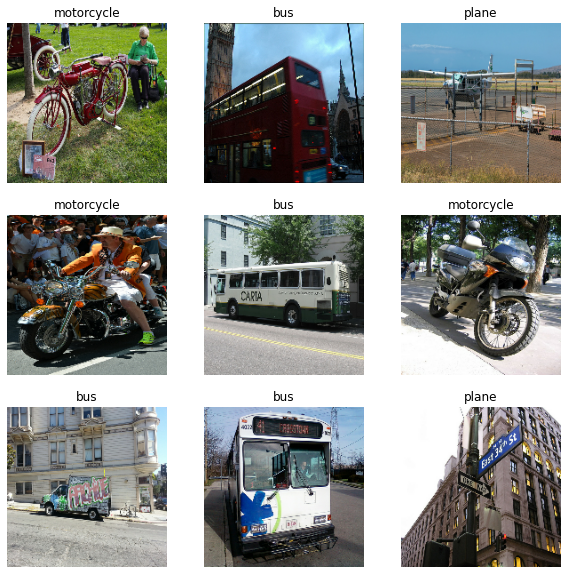

In [10]:
#transforming metrics back to images to comfirm format of images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [11]:
#checking tradeoff between using many layers (i.e. having a “deeper” network) and accuracy? And layers and time
#Reducing layers
#using 1 convulation layer and 1 max pooling layer
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 129600)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               16588928  
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

In [12]:
#model training, setting learning to 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_loss']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 59s 535ms/step - loss: 3.2545 - accuracy: 0.4327 - val_loss: 1.0876 - val_accuracy: 0.5516
Epoch 2/10
108/108 [==============================] - 74s 684ms/step - loss: 0.9361 - accuracy: 0.6304 - val_loss: 1.1332 - val_accuracy: 0.5133
Epoch 3/10
108/108 [==============================] - 74s 683ms/step - loss: 0.6789 - accuracy: 0.7537 - val_loss: 1.0335 - val_accuracy: 0.5817
Epoch 4/10
108/108 [==============================] - 73s 678ms/step - loss: 0.4220 - accuracy: 0.8770 - val_loss: 1.1231 - val_accuracy: 0.5747
Epoch 5/10
108/108 [==============================] - 73s 674ms/step - loss: 0.2707 - accuracy: 0.9372 - val_loss: 1.2613 - val_accuracy: 0.5353
Epoch 6/10
108/108 [==============================] - 73s 679ms/step - loss: 0.2053 - accuracy: 0.9540 - val_loss: 1.3392 - val_accuracy: 0.5550
Epoch 7/10
108/108 [==============================] - 72s 670ms/step - loss: 0.1708 - accuracy: 0.9638 - val_loss: 1.4197 - val_ac

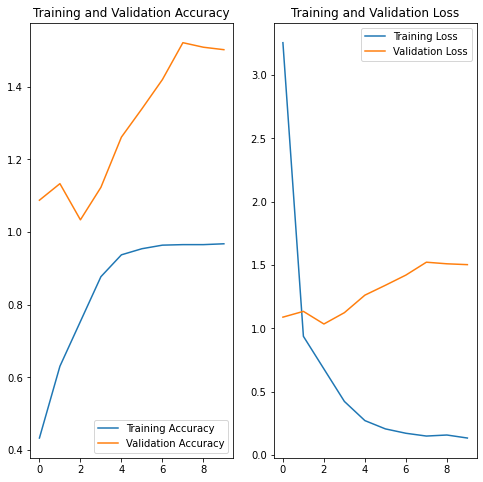

In [13]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(32, 180, 180, 3)
(32,)


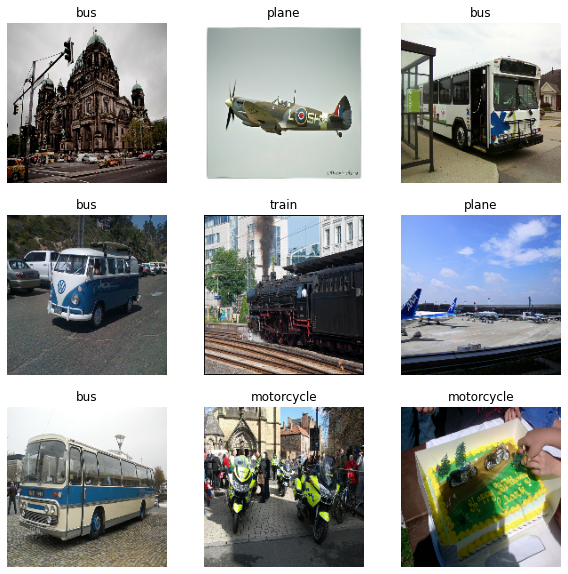

In [14]:
#transforming metrics back to images to comfirm format of images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [15]:
#effect of changing the pooling mechanism, e.g. average vs max
#using Average pooling

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 90, 90, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 45, 45, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 64)       

In [16]:
#model training, setting learning to 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_loss']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 272s 3s/step - loss: 1.2277 - accuracy: 0.4452 - val_loss: 1.0792 - val_accuracy: 0.5597
Epoch 2/10
108/108 [==============================] - 105s 976ms/step - loss: 1.0177 - accuracy: 0.5670 - val_loss: 1.0100 - val_accuracy: 0.6002
Epoch 3/10
108/108 [==============================] - 108s 1s/step - loss: 0.9227 - accuracy: 0.6156 - val_loss: 0.9855 - val_accuracy: 0.6083
Epoch 4/10
108/108 [==============================] - 104s 965ms/step - loss: 0.8085 - accuracy: 0.6686 - val_loss: 1.0188 - val_accuracy: 0.5701
Epoch 5/10
108/108 [==============================] - 108s 1000ms/step - loss: 0.6673 - accuracy: 0.7433 - val_loss: 1.0750 - val_accuracy: 0.5782
Epoch 6/10
108/108 [==============================] - 108s 996ms/step - loss: 0.5109 - accuracy: 0.8046 - val_loss: 1.4474 - val_accuracy: 0.5295
Epoch 7/10
108/108 [==============================] - 508s 5s/step - loss: 0.4023 - accuracy: 0.8434 - val_loss: 1.3388 - val_acc

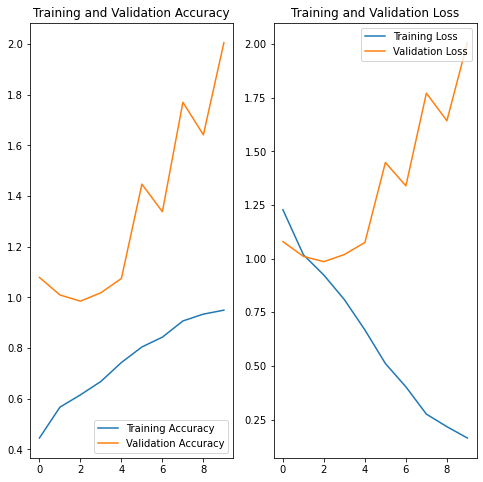

In [17]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(32, 180, 180, 3)
(32,)


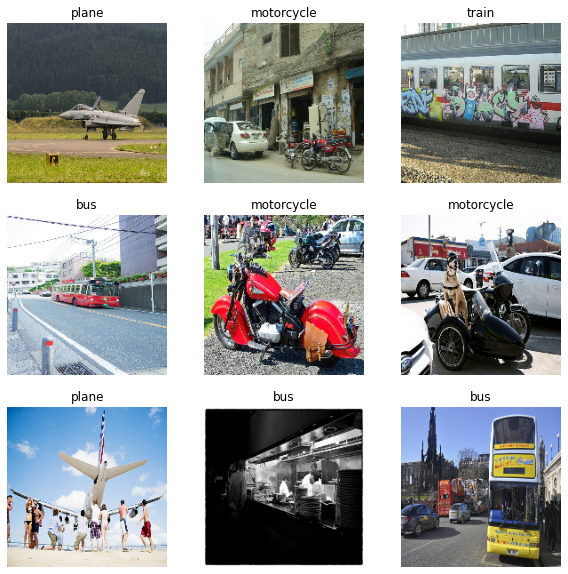

In [18]:
#transforming metrics back to images to comfirm format of images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# collected image of 4 categories

In [19]:
#my collected image of 4 categories
# Data processing, preparing learning to recognise objects
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

data_dir = 'C:/Users/Dayo Tosin Oyeyemi/Desktop/Computer_vision/Vehicles_pictures'

#defining parameters

batch_size = 32
img_height = 180
img_width = 180

#using keras/tensorflow method image_dataset_from_directory to transform my images into numeric metrics.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 20 files belonging to 4 classes.
Using 16 files for training.
Found 20 files belonging to 4 classes.
Using 4 files for validation.
['bus', 'motorcycle', 'plane', 'train']


In [20]:
#using tensorflow's Autotune to pre-fetch the data, catch it for availablity for learning models
#tensorsflow's optimisation method

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

num_classes = 4

0.0 1.0


In [21]:
#defining CNN, I fed in the original image shape retrived above but rescale to range 0-1.
#using 3 convulation layers and 3 max pooling layers

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 64)       

In [22]:
#model training, setting learning to 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_loss']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.3926 - accuracy: 0.2500 - val_loss: 2.0287 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 1s 676ms/step - loss: 1.7531 - accuracy: 0.2500 - val_loss: 2.2770 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 1s 666ms/step - loss: 1.6757 - accuracy: 0.2500 - val_loss: 1.4619 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 664ms/step - loss: 1.0101 - accuracy: 0.6875 - val_loss: 1.2768 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 1s 727ms/step - loss: 0.9073 - accuracy: 0.6250 - val_loss: 1.2514 - val_accuracy: 0.2500
Epoch 6/10
1/1 [==============================] - 1s 647ms/step - loss: 0.8362 - accuracy: 0.6875 - val_loss: 1.1808 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 694ms/step - loss: 0.6466 - accuracy: 0.8750 - val_loss: 1.1738 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=======

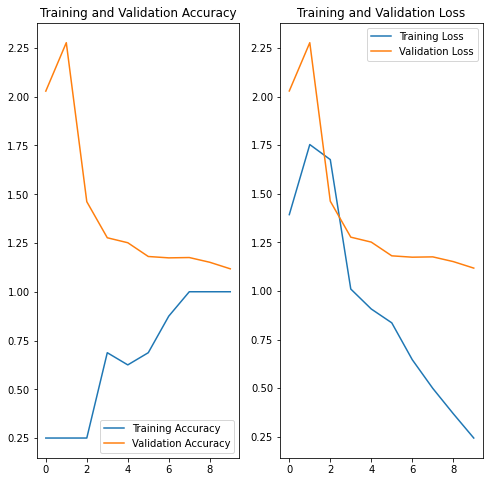

In [23]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(16, 180, 180, 3)
(16,)


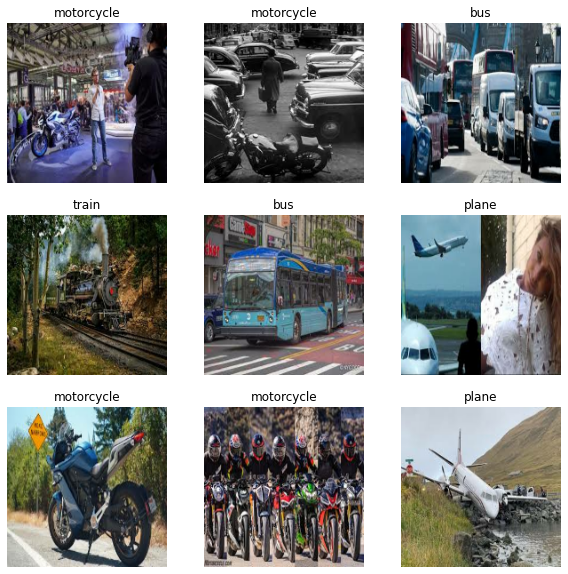

In [24]:
#transforming metrics back to images to comfirm format of images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

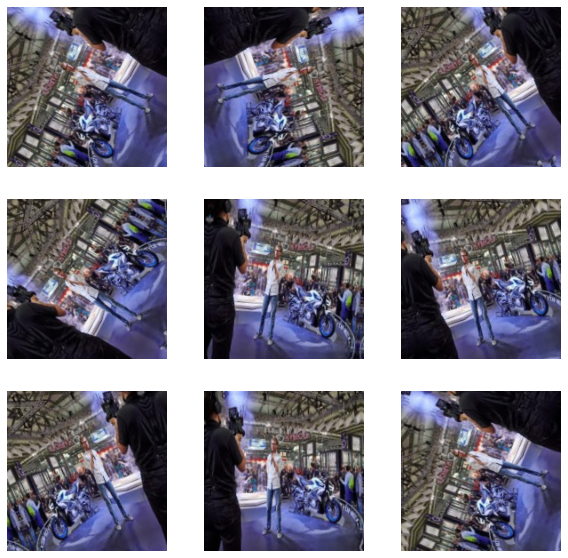

In [25]:
#using augmenation to improve performance
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [26]:
#model training, setting learning to 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_loss']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
1/1 [==============================] - 1s 638ms/step - loss: 0.1479 - accuracy: 1.0000 - val_loss: 1.1038 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 1s 589ms/step - loss: 0.0827 - accuracy: 1.0000 - val_loss: 1.1483 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 1s 642ms/step - loss: 0.0442 - accuracy: 1.0000 - val_loss: 1.3115 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 1s 662ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 1.5249 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 1s 713ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 1.7434 - val_accuracy: 0.2500
Epoch 6/10
1/1 [==============================] - 1s 667ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.9730 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 664ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.2005 - val_accuracy: 0.2500
Epoch 8/10
1/1 [====

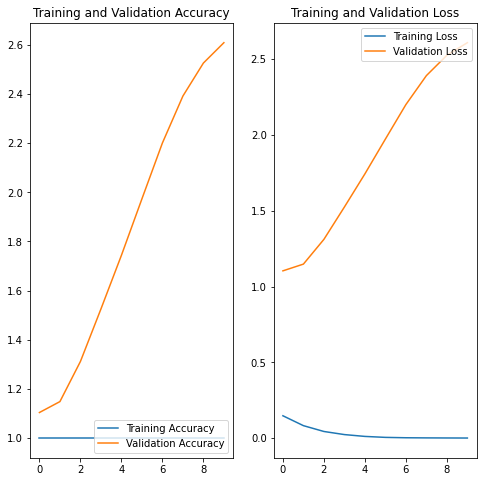

In [27]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(16, 180, 180, 3)
(16,)


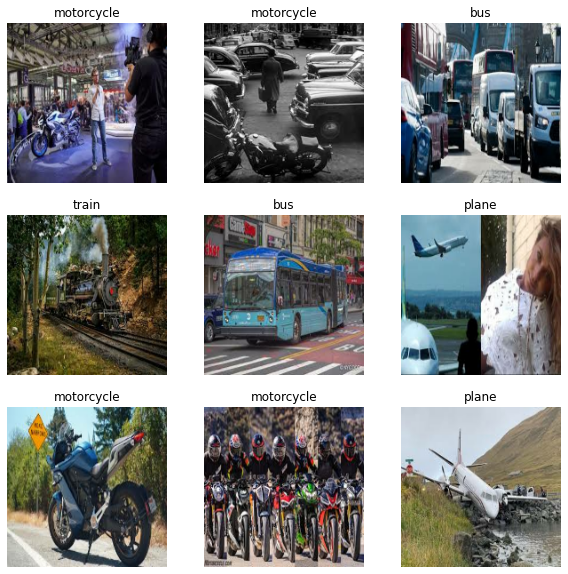

In [28]:
#transforming metrics back to images to comfirm format of images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Using feature extraction from pre-trained models

In [31]:
# Create the base model from the pre-trained moel MobileNet V2
import tensorflow as tf
data_dir = 'C:/Users/Dayo Tosin Oyeyemi/Desktop/Computer_vision/vehicles_images'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)



img_height = 160
img_width = 160
batch_size = 32
IMG_SIZE = (img_height, img_width)
IMG_SHAPE= IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
(32, 5, 5, 1280)


In [32]:
#Creating base model
base_model.trainable= False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [33]:
#generating predictions
predicton_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [34]:
#input pre-processing
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [35]:
#learning model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary() 

len(model.trainable_variables)
              
initial_epochs = 10
              
loss0, accuracy0 = model.evaluate(val_ds)
              
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
              
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Found 4318 files belonging to 4 classes.
Using 863 files for validation.


c:\Users\Dayo Tosin Oyeyemi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

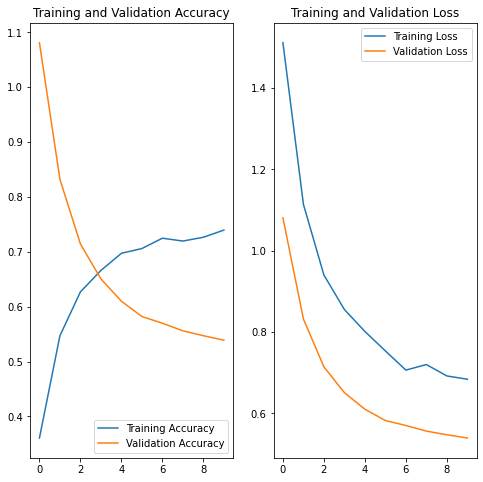

In [36]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
import matplotlib.pyplot as plt
epochs = 10
epochs_range = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_loss']
loss= history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
#Fine-tunnig model weights from pre-trained model
base_model.trainable = True
base_model.summary()

print("Number of layers in the base model:", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [38]:
#base model unfreeze, instructing learner exactly from which layers to resume training
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

c:\Users\Dayo Tosin Oyeyemi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [39]:
#continue training adding fine-tunning epochs to normal training epochs
initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
                         

Epoch 10/20
108/108 [==============================] - 197s 2s/step - loss: 0.6605 - accuracy: 0.7465 - val_loss: 0.5188 - val_accuracy: 0.8065
Epoch 11/20
108/108 [==============================] - 189s 2s/step - loss: 0.6172 - accuracy: 0.7563 - val_loss: 0.5287 - val_accuracy: 0.7995
Epoch 12/20
108/108 [==============================] - 198s 2s/step - loss: 0.5575 - accuracy: 0.7792 - val_loss: 0.4975 - val_accuracy: 0.8227
Epoch 13/20
108/108 [==============================] - 200s 2s/step - loss: 0.5434 - accuracy: 0.7925 - val_loss: 0.5025 - val_accuracy: 0.8123
Epoch 14/20
108/108 [==============================] - 351s 3s/step - loss: 0.5213 - accuracy: 0.7962 - val_loss: 0.5062 - val_accuracy: 0.8042
Epoch 15/20
108/108 [==============================] - 198s 2s/step - loss: 0.5114 - accuracy: 0.8049 - val_loss: 0.4929 - val_accuracy: 0.8181
Epoch 16/20
108/108 [==============================] - 217s 2s/step - loss: 0.4740 - accuracy: 0.8185 - val_loss: 0.4830 - val_accuracy:

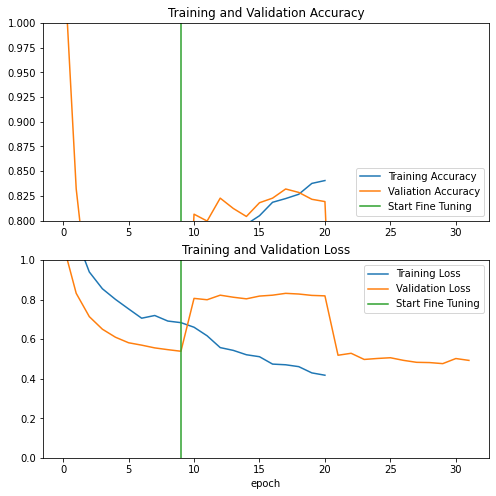

In [40]:
#plot of learning process using accuracy, validation accuracy, loss and validation loss information from my model training
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Valiation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
loss, accuracy = model.evaluate(train_ds)
print('Test accuracy :', accuracy)

108/108 [==============================] - 89s 813ms/step - loss: 0.3360 - accuracy: 0.8761
Test accuracy : 0.8761215806007385
